In [83]:
#Importing libraries needed for the project
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
import seaborn as sb

In [58]:
data=pd.read_csv("/home/kasia/data_ML/ML_data.csv")

In [59]:
data=data.set_index("id")

data["diagnosis_binary"]=data["diagnosis"]
data["diagnosis_binary"]=data["diagnosis_binary"].replace("B",0)
data["diagnosis_binary"]=data["diagnosis_binary"].replace("M",1)
data_ML=data.drop("diagnosis", axis=1)

/tmp/ipykernel_1395/2161451360.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["diagnosis_binary"]=data["diagnosis_binary"].replace("M",1)


In [60]:
#Select columns with mean
X=data_ML.iloc[:,0:10]
Y=data_ML["diagnosis_binary"]

In [61]:
Y.value_counts()
#there is a class imbalance in the data - more classified as 0 than 1
#to correct for class imbalance SMOTE is used
smote=SMOTE(random_state=42, sampling_strategy="minority")
X_res, Y_res=smote.fit_resample(X,Y)

In [62]:
#Splitting the data into the training and testing datasets, by default test is 25% of the data
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res)

/home/kasia/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kasia/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


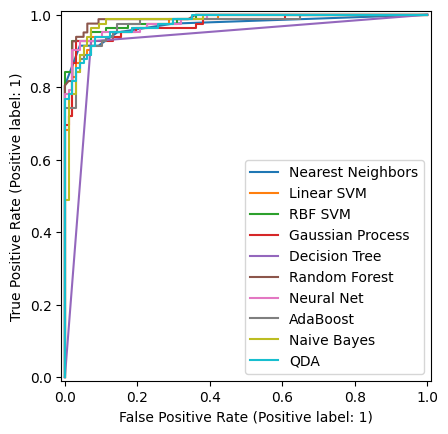

In [63]:
#Comparing ML classifiers for their potential to predict the class based on the features
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier( random_state=42),
    MLPClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
ax=plt.gca()
scores={"Accuracy":[], "Precision":[],"Recall":[],"F1":[]}
ROC={}
for classifier in classifiers:
    pipe=make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, Y_train)
    prediction=pipe.predict(X_test)
    scores["Accuracy"].append(accuracy_score(prediction, Y_test))
    scores["F1"].append(f1_score(prediction, Y_test))
    scores["Recall"].append(recall_score(prediction, Y_test))
    scores["Precision"].append(precision_score(prediction, Y_test))
    RocCurveDisplay.from_estimator(pipe, X_test, Y_test, ax=ax)
ax.legend(names)


In [64]:
comparison=pd.DataFrame(scores)
comparison["Models"]=names
comparison=comparison.set_index("Models")

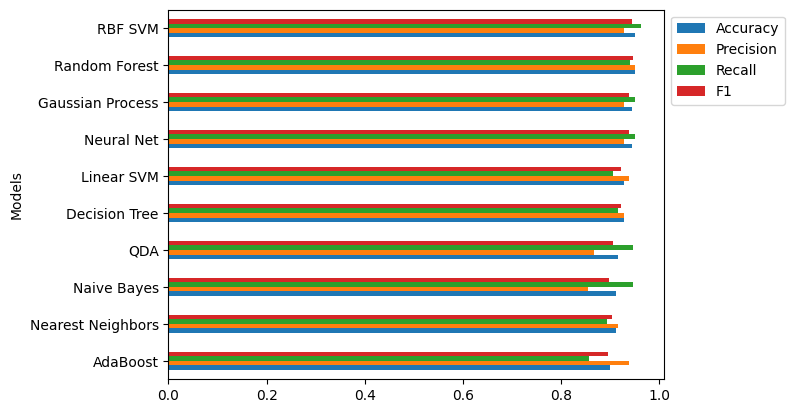

In [65]:
sorted=comparison.sort_values(by="Accuracy", ascending=True)
ax=sorted.plot.barh()
ax.legend(bbox_to_anchor=(1,1))

In [71]:
sorted

,Accuracy,Precision,Recall,F1
Models,,,,
AdaBoost,0.899441,0.939024,0.855556,0.895349
Nearest Neighbors,0.910615,0.914634,0.892857,0.903614
Naive Bayes,0.910615,0.853659,0.945946,0.897436
QDA,0.916201,0.865854,0.946667,0.904459
Decision Tree,0.927374,0.926829,0.915663,0.921212
Linear SVM,0.927374,0.939024,0.905882,0.922156
Neural Net,0.944134,0.926829,0.950000,0.938272
Gaussian Process,0.944134,0.926829,0.950000,0.938272
Random Forest,0.949721,0.951220,0.939759,0.945455


In [76]:
#Hyperparameter tuning for the top 3 models
#RBF_classifier
pipe=make_pipeline(StandardScaler(), SVC(random_state=42, kernel="rbf"))
params={"svc__C":[0.01,0.1,0.5,1],
        "svc__gamma":["scale","auto"],
        "svc__shrinking":[True, False],
        "svc__probability":[True, False]
        }

clf=GridSearchCV(pipe,param_grid=params,scoring="accuracy")
clf.fit(X_train, Y_train)
clf.best_params_

#This analysis indicated the best parameters and hence these are applied in the next steps for feature importance

{'svc__C': 1,
 'svc__gamma': 'scale',
 'svc__probability': True,
 'svc__shrinking': True}

In [77]:
pipe=make_pipeline(StandardScaler(),SVC(random_state=42, kernel="rbf", probability=True, shrinking=True,
                                        C=1, gamma="scale"))
pipe.fit(X_train, Y_train)
importances=permutation_importance(pipe, X, Y, random_state=42)
df_importances=pd.DataFrame(importances.importances.T)
df_importances.columns=X.columns

[Text(1, 0, 'radius_mean'),
 Text(2, 0, 'texture_mean'),
 Text(3, 0, 'perimeter_mean'),
 Text(4, 0, 'area_mean'),
 Text(5, 0, 'smoothness_mean'),
 Text(6, 0, 'compactness_mean'),
 Text(7, 0, 'concavity_mean'),
 Text(8, 0, 'concave points_mean'),
 Text(9, 0, 'symmetry_mean'),
 Text(10, 0, 'fractal_dimension_mean')]

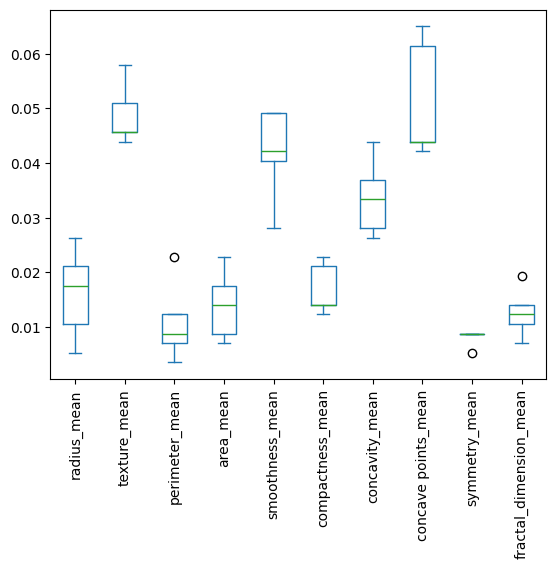

In [78]:
ax=df_importances.plot.box()
ax.set_xticklabels(df_importances.columns,rotation=90)

In [79]:
#Overall the model performs very well but the feature permutation importance seems to be very low
#This could stem from multicolinearity
#Thus calculate correlation matrix and then plot as heatmap to see what is happening
corr_matrix=X.corr()

<Axes: >

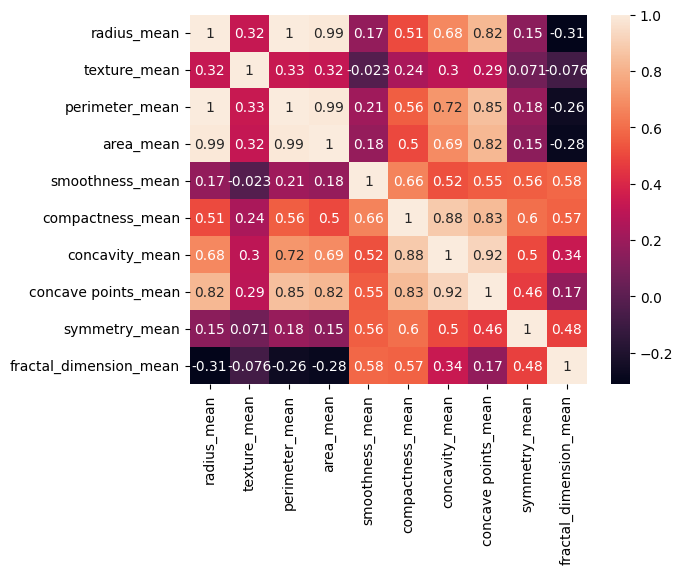

In [87]:
sb.heatmap(corr_matrix,annot=True)